In [15]:
!pip install tensorflow keras

In [16]:
import tensorflow as tf
print (tf.keras.__version__)

3.8.0


In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image # Import Pillow
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [30]:
# Define dataset paths
train_dir = "/content/drive/MyDrive/FruitinAmazon/train"  # Path to training data
test_dir = "/content/drive/MyDrive/FruitinAmazon/train"    # Path to testing data

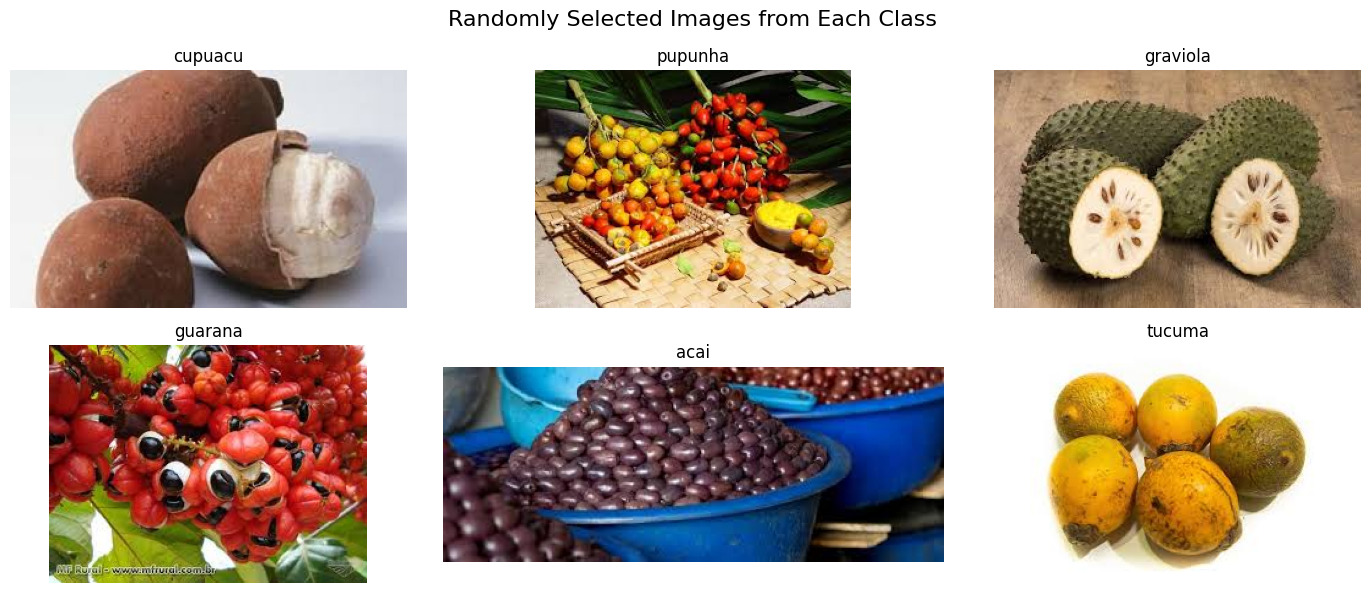

In [20]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Get the list of class directories
classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Randomly select one image from each class
selected_images = []
for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    image_file = random.choice(os.listdir(class_path))  # Randomly pick one image
    selected_images.append((class_name, os.path.join(class_path, image_file)))

# Plot the images in a grid format
fig, axes = plt.subplots(2, len(classes) // 2, figsize=(15, 6))  # Adjust the grid as needed
fig.suptitle("Randomly Selected Images from Each Class", fontsize=16)

for i, (class_name, image_path) in enumerate(selected_images):
    img = mpimg.imread(image_path)
    ax = axes[i // (len(classes) // 2), i % (len(classes) // 2)]
    ax.imshow(img)
    ax.set_title(class_name)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [21]:
# Create a list to store paths of corrupted images
corrupted_images = []

# Get all class directories in the train directory
class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Loop through each class directory
for class_dir in class_dirs:
    class_folder = os.path.join(train_dir, class_dir)
    for image_name in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_name)
        try:
            # Try to open the image
            with Image.open(image_path) as img:
                img.verify()  # Verify the image is valid
        except (IOError, SyntaxError):  # Catch errors for corrupted images
            corrupted_images.append(image_path)  # Log the corrupted image path
            os.remove(image_path)  # Delete the corrupted image
            print(f"Corrupted image removed: {image_path}")

# Display final summary
if not corrupted_images:
    print("No corrupted images found.")
else:
    print(f"Total number of corrupted images removed: {len(corrupted_images)}")
    print("Corrupted images list:")
    for image_path in corrupted_images:
        print(image_path)


No corrupted images found.


In [22]:
# Define image size and batch size
img_height = 128  # Example image height
img_width = 128   # Example image width
batch_size = 32
validation_split = 0.2  # 80% training, 20% validation

# Create a preprocessing layer for normalization
rescale = tf.keras.layers.Rescaling(1./255)  # Normalize pixel values to [0, 1]

# Create training dataset with normalization
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

# Apply the normalization (Rescaling) to the training dataset
train_ds = train_ds.map(lambda x, y: (rescale(x), y))

# Create validation dataset with normalization
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

# Apply the normalization (Rescaling) to the validation dataset
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

# Optional: Inspect the datasets
for images, labels in train_ds.take(1):
    print("Training batch shape:", images.shape, "Labels:", labels.numpy())

for images, labels in val_ds.take(1):
    print("Validation batch shape:", images.shape, "Labels:", labels.numpy())

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.
Training batch shape: (32, 128, 128, 3) Labels: [1 0 5 4 4 5 2 3 0 4 0 3 3 3 0 0 5 5 2 5 3 4 2 1 5 0 2 4 3 0 1 1]
Validation batch shape: (18, 128, 128, 3) Labels: [4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


In [25]:
# Function to create the Convolutional Neural Network (CNN) model
def build_cnn_model(num_classes, input_shape=(128, 128, 3)):
    model = keras.Sequential([
        # First Convolutional Layer
        layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding="same", activation="relu", input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),

        # Second Convolutional Layer
        layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),

        # Flatten the output
        layers.Flatten(),

        # Fully Connected (Dense) Layers
        layers.Dense(64, activation="relu"),
        layers.Dense(128, activation="relu"),

        # Output Layer (Softmax Activation for Multi-Class Classification)
        layers.Dense(num_classes, activation="softmax")
    ])

    return model

# Example of creating a model
num_classes = 10  # Adjust with the actual number of classes in your dataset
model = build_cnn_model(num_classes)
model.summary()  # Display the model architecture


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,970 (8.08 MB)

 Trainable params: 2,116,970 (8.08 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),  # SGD with momentum
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,970 (8.08 MB)

 Trainable params: 2,116,970 (8.08 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# Set up callbacks
checkpoint = ModelCheckpoint(
    "best_model.h5",  # File to save the best model
    monitor="val_loss",  # Track validation loss
    save_best_only=True,  # Only save the best model
    mode="min",  # Lower validation loss is preferred
    verbose=1
)

early_stopping = EarlyStopping(
    monitor="val_loss",  # Track validation loss
    patience=10,  # Stop training if no improvement for 10 epochs
    restore_best_weights=True,  # Revert to the best model weights
    verbose=1
)

# Train the model
training_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,  # Train for a total of 250 epochs
    batch_size=16,  # Set batch size to 16
    callbacks=[checkpoint, early_stopping]  # Use the defined callbacks
)


Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.1042 - loss: 2.2844
Epoch 1: val_loss improved from inf to 2.09597, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 653ms/step - accuracy: 0.1094 - loss: 2.2798 - val_accuracy: 0.0000e+00 - val_loss: 2.0960
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.1956 - loss: 1.9978
Epoch 2: val_loss did not improve from 2.09597
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 454ms/step - accuracy: 0.1918 - loss: 1.9941 - val_accuracy: 0.1667 - val_loss: 2.2682
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.1649 - loss: 1.8847
Epoch 3: val_loss did not improve from 2.09597
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 526ms/step - accuracy: 0.1654 - loss: 1.8834 - val_accuracy: 0.0000e+00 - val_loss: 2.4378
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.1395 - loss: 1.9009
Epoch 4: val_loss improved from 2.09597 to 1.88222, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 500ms/step - accuracy: 0.1428 - loss: 1.8920 - val_accuracy: 0.0000e+00 - val_loss: 1.8822
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.4028 - loss: 1.7226
Epoch 5: val_loss improved from 1.88222 to 1.58436, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 882ms/step - accuracy: 0.3854 - loss: 1.7287 - val_accuracy: 0.1667 - val_loss: 1.5844
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.2870 - loss: 1.7183
Epoch 6: val_loss did not improve from 1.58436
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 469ms/step - accuracy: 0.2743 - loss: 1.7314 - val_accuracy: 0.2222 - val_loss: 1.7325
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.2251 - loss: 1.7173
Epoch 7: val_loss improved from 1.58436 to 1.22599, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 494ms/step - accuracy: 0.2244 - loss: 1.7183 - val_accuracy: 0.8333 - val_loss: 1.2260
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.3096 - loss: 1.6167
Epoch 8: val_loss did not improve from 1.22599
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 475ms/step - accuracy: 0.3121 - loss: 1.6191 - val_accuracy: 0.0556 - val_loss: 1.9178
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.3391 - loss: 1.4375
Epoch 9: val_loss did not improve from 1.22599
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 524ms/step - accuracy: 0.3446 - loss: 1.4398 - val_accuracy: 0.6111 - val_loss: 1.3706
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.4300 - loss: 1.2664
Epoch 10: val_loss improved from 1.22599 to 1.00081, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 821ms/step - accuracy: 0.4301 - loss: 1.2684 - val_accuracy: 0.6667 - val_loss: 1.0008
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step - accuracy: 0.5509 - loss: 1.0753
Epoch 11: val_loss did not improve from 1.00081
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 489ms/step - accuracy: 0.5451 - loss: 1.0808 - val_accuracy: 0.1667 - val_loss: 1.5696
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.5804 - loss: 1.0058
Epoch 12: val_loss improved from 1.00081 to 0.77366, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 501ms/step - accuracy: 0.5777 - loss: 1.0091 - val_accuracy: 0.7778 - val_loss: 0.7737
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.5341 - loss: 0.9528
Epoch 13: val_loss did not improve from 0.77366
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 527ms/step - accuracy: 0.5395 - loss: 0.9507 - val_accuracy: 0.3333 - val_loss: 1.8630
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.6748 - loss: 0.8431
Epoch 14: val_loss did not improve from 0.77366
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 469ms/step - accuracy: 0.6762 - loss: 0.8374 - val_accuracy: 0.3333 - val_loss: 1.5337
Epoch 15/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.7998 - loss: 0.5211
Epoch 15: val_loss did not improve from 0.77366
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 456ms/step - accuracy: 0.8012 - loss: 0.5211 - val_accuracy: 0.7778 - val_loss: 0.9169
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.8646 - loss: 0.3994
Epoch 16: val_loss did not improve from 0.77366
3/3 

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 572ms/step - accuracy: 0.7886 - loss: 0.5411 - val_accuracy: 0.8889 - val_loss: 0.4024
Epoch 19/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.8397 - loss: 0.4671
Epoch 19: val_loss did not improve from 0.40245
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 452ms/step - accuracy: 0.8416 - loss: 0.4606 - val_accuracy: 0.8333 - val_loss: 0.6610
Epoch 20/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.9502 - loss: 0.2057
Epoch 20: val_loss did not improve from 0.40245
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 450ms/step - accuracy: 0.9488 - loss: 0.2065 - val_accuracy: 0.8333 - val_loss: 0.6072
Epoch 21/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.9803 - loss: 0.1529
Epoch 21: val_loss did not improve from 0.40245
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step - accuracy: 0.9783 - loss: 0.1557 - val_accuracy: 0.8889 - val_loss: 0.5327
Epoch 22/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 1.0000 - loss: 0.0254
Epoch 22: val_loss did not improve from 0.40245
3/3 

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 502ms/step - accuracy: 1.0000 - loss: 0.0171 - val_accuracy: 0.8333 - val_loss: 0.3624
Epoch 25/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9265 - loss: 0.3566
Epoch 25: val_loss did not improve from 0.36243
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 459ms/step - accuracy: 0.9171 - loss: 0.4015 - val_accuracy: 0.0556 - val_loss: 10.5239
Epoch 26/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.4034 - loss: 4.6244
Epoch 26: val_loss did not improve from 0.36243
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 469ms/step - accuracy: 0.4136 - loss: 4.3853 - val_accuracy: 0.8333 - val_loss: 0.6209
Epoch 27/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.5706 - loss: 1.2934
Epoch 27: val_loss did not improve from 0.36243
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 517ms/step - accuracy: 0.5668 - loss: 1.3125 - val_accuracy: 0.0556 - val_loss: 1.9204
Epoch 28/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.2992 - loss: 1.6992
Epoch 28: val_loss did not improve from 0.36243
3/3

In [37]:
# Create the test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,  # Directory containing the test dataset
    label_mode='int',
    image_size=(128, 128),
    batch_size=32,
    shuffle=False
)

# Evaluate the model on the test dataset
loss, accuracy = model.evaluate(test_dataset)

# Output the test loss and accuracy
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


Found 90 files belonging to 6 classes.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.7600 - loss: 302.9040
Test Loss: 314.8688049316406
Test Accuracy: 0.7777777910232544


In [38]:
model = tf.keras.models.load_model('best_model.h5')

#Evaluate
test_loss, test_accuracy = model.evaluate(val_ds)
print(f"Test accuracy: {test_accuracy}")

# Save final model
model.save('fruit_classifier_final.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step - accuracy: 0.8333 - loss: 0.3624


Test accuracy: 0.8333333134651184


In [65]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report

# Load dataset and get class names
raw_val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/FruitinAmazon/train",
    image_size=(128, 128),
    batch_size=16,
    shuffle=False
)

# Get and print class names
class_names = raw_val_ds.class_names
print("Class Names:", class_names)

# Apply normalization
val_ds = raw_val_ds.map(lambda x, y: (x / 255.0, y))

# Make predictions
predictions = model.predict(val_ds)
predicted_labels = np.argmax(predictions, axis=1)

# Get true labels
true_labels = np.concatenate([y.numpy() for _, y in val_ds])

# Generate and print classification report
print("\nClassification Report:")
print(classification_report(
    true_labels,
    predicted_labels,
    target_names=class_names,
    digits=2,
    zero_division=0
))



Found 90 files belonging to 6 classes.
Class Names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step

Classification Report:
              precision    recall  f1-score   support

        acai       0.94      1.00      0.97        15
     cupuacu       1.00      0.87      0.93        15
    graviola       1.00      0.93      0.97        15
     guarana       0.92      0.80      0.86        15
     pupunha       0.72      0.87      0.79        15
      tucuma       0.81      0.87      0.84        15

    accuracy                           0.89        90
   macro avg       0.90      0.89      0.89        90
weighted avg       0.90      0.89      0.89        90



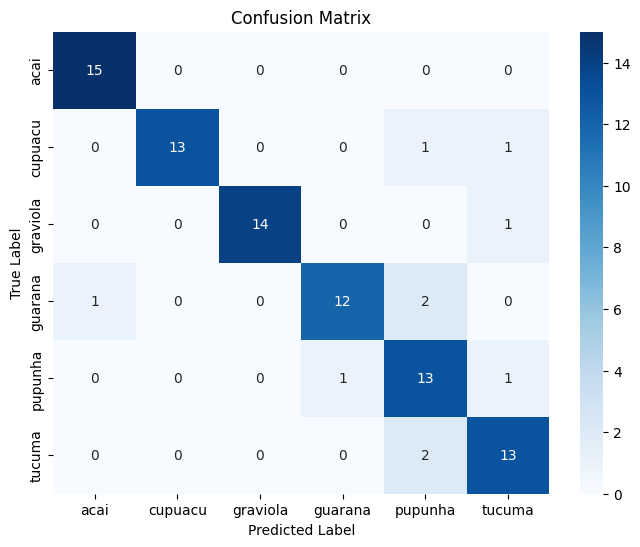

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create figure
plt.figure(figsize=(8 , 6))

# Plot heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)

# Formatting
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Show plot
plt.show()